# **IMPORTS**

In [ ]:
!pip install pyspellchecker
!pip install langdetect
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
!pip install pyenchant
!pip install transformers


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import joblib
import pickle
from joblib import dump
from joblib import load
import string
from spellchecker import SpellChecker
from langdetect import detect
from sklearn import metrics
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LOADING DATA**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/electronics_sample.csv')
df

,overall,vote,reviewTime,reviewText,summary
0,2,0,2010-02-10,Tech support is the worst,1265760000
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable
...,...,...,...,...,...
19804,3,0,2014-11-11,rendering lens useless in darkness,1415664000
19805,1,0,2015-03-14,One Star,1426291200
19806,4,0,2009-03-27,Decent Cable for the Money,1238112000
19807,3,2,2014-06-06,OK drop protection for reasonable price.,1402012800


In [ ]:
new_df = df[['overall', 'reviewText']].copy()
new_df = new_df.loc[new_df['overall'] != 3]
new_df

,overall,reviewText
0,2,Tech support is the worst
1,2,Screws were missing from the bracket and beaut...
2,1,Trouble connecting and staying connected via b...
3,4,I purchased this unit for our RV to replace an...
5,1,I bought this and a viper alarm for my civic a...
...,...,...
19801,5,Having just finished wall mounting four speake...
19803,5,Cmara digital
19805,1,One Star
19806,4,Decent Cable for the Money


In [ ]:
new_df['overall'] = new_df['overall'].apply(lambda x: 1 if x <= 2 else 0)
new_df

,overall,reviewText
0,1,Tech support is the worst
1,1,Screws were missing from the bracket and beaut...
2,1,Trouble connecting and staying connected via b...
3,0,I purchased this unit for our RV to replace an...
5,1,I bought this and a viper alarm for my civic a...
...,...,...
19801,0,Having just finished wall mounting four speake...
19803,0,Cmara digital
19805,1,One Star
19806,0,Decent Cable for the Money


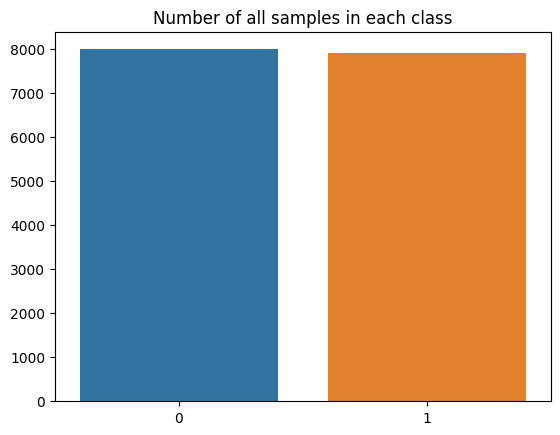

0    7988
1    7899
Name: overall, dtype: int64


In [ ]:
class_counts = new_df['overall'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of all samples in each class')
plt.show()
print(class_counts)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/amazon_reviews.csv')
df2

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551154,Greg,True,Pandahall 10m(32.80 feet) Platinum Color Iron ...,"['Iron Twist Chains, Platinum Color<P>Size: Ri...",['https://images-na.ssl-images-amazon.com/imag...,PH PandaHall,"['Iron Twist Chains, Platinum Color, Ring: abo...",Arts_Crafts_and_Sewing,$8.29,2.0,2018-10-03,Two Stars,Cheap price but weak chain.,0
551155,Gayle LaRue,True,Keter Westwood Plastic Deck Storage Container ...,"['Plenty of storage and comfortable seating, a...",['https://images-na.ssl-images-amazon.com/imag...,Keter,['Outside Dimensions: 61 in. L x 28.5 in. W x ...,Patio_Lawn_and_Garden,$121.76,4.0,2018-10-03,Deck box good investment,Great deck box,0
551156,Alfred D. Wallace,True,AcuRite 06052M Remote Battery Pack for 5-in-1 ...,"[""The AcuRite remote battery pack plugs into t...",['https://images-na.ssl-images-amazon.com/imag...,AcuRite,['Makes battery replacement easy for AcuRite 5...,Patio_Lawn_and_Garden,$19.95,5.0,2018-10-03,This will keep the old man off the roof!,Putting these in my weather station. I anticip...,0
551157,Dave Dunn Wilmer,True,Keter Unity XL Indoor Outdoor Entertainment BB...,['The extra-large outdoor entertainment statio...,['https://images-na.ssl-images-amazon.com/imag...,Keter,['Dimensions: 53.1 in. L x 20.4 in. W x 35.4 i...,Patio_Lawn_and_Garden,$155.64,5.0,2018-10-03,EASY TO ASSEMBLE AND WORKS WELL NEXT TO GRILL,This is a nice quality grilling table where yo...,0


In [ ]:
# Filter the DataFrame to keep only the rows with the specific category
new_df2 = df2[df2['category'].isin(['Cell_Phones_and_Accessories', 'Video_Games'])]

# Reset the index of the DataFrame
new_df2.reset_index(drop=True, inplace=True)
new_df2

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Daniel,True,Cimo Slim Flexible TPU Cimo Shock Absorbing Ca...,[],['https://images-na.ssl-images-amazon.com/imag...,Cimo,"['Made of shock absorbing, shatterproof premiu...",Cell_Phones_and_Accessories,$7.98,5.0,2018-01-01,Slim and elegant,Slim and neat. The phone is protected an looks...,0
1,Dariela,True,Razer DeathAdder Expert - Optical Esports Ergo...,"['', 'Since its first inception, the Razer Dea...",['https://images-na.ssl-images-amazon.com/imag...,Razer,['The Razer DeathAdder continues to offer game...,Video_Games,$2.54,5.0,2018-01-01,Great mouse,I've had since 2015 and this cutie is still wo...,0
2,Cookies,True,"iPhone 8 Plus, 7 Plus, 6S Plus, 6 Plus Screen ...",[],['https://images-na.ssl-images-amazon.com/imag...,amFilm,"['Specifically designed for iPhone 8 Plus, 7 P...",Cell_Phones_and_Accessories,$7.99,5.0,2018-01-01,Five Stars,Gifted - loved and has protected the phone,0
3,Chief,False,"Anker 15W Dual USB Solar Charger, PowerPort So...",['Note: Use screwdriver to tighten the screw p...,['https://images-na.ssl-images-amazon.com/imag...,Anker,['The Anker Advantage: Join the 10 million+ po...,Cell_Phones_and_Accessories,$39.99,4.0,2018-01-01,Solid solid calharger,So far this little dual solar panel works! Its...,0
4,Momma,True,"Tekcoo Galaxy S5 Case, [Tmajor] Sturdy [Hot Pi...",['Features:<br> <br> -100% Brand New and good ...,['https://images-na.ssl-images-amazon.com/imag...,Tekcoo,['Tekcoo Dual Layer Armor Rugged Samsung Galax...,Cell_Phones_and_Accessories,$7.85,2.0,2018-01-01,The loose rubbery edges near the top and botto...,The loose rubbery edges near the top and botto...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54652,Speed E Byer,True,Watch Dogs 2 - Xbox One,"[""Explore the birthplace of the tech revolutio...",['https://images-na.ssl-images-amazon.com/imag...,by\n \n Ubisoft,['Explore a massive and dynamic open world - E...,Video_Games,\n\t\t ...,4.0,2018-10-01,Four Stars,intense have to get use to the play action,0
54653,D. Lyons,True,Kartice for Fitbit Blaze Charger Charging Stan...,[],['https://images-na.ssl-images-amazon.com/imag...,Kartice,"['Specially designed for 2016 Fitbit Blaze,mor...",Cell_Phones_and_Accessories,$8.99,5.0,2018-10-01,Five Stars,perfect and easy works great,0
54654,gragsinc,True,Kartice for Fitbit Blaze Charger Charging Stan...,[],['https://images-na.ssl-images-amazon.com/imag...,Kartice,"['Specially designed for 2016 Fitbit Blaze,mor...",Cell_Phones_and_Accessories,$8.99,5.0,2018-10-02,Works Amazingly!,So much better than the stock charger that cam...,0
54655,angel b,True,"RAMPOW Micro USB Cables Braided, Charging Cabl...",[],['https://images-na.ssl-images-amazon.com/imag...,RAMPOW,['FAST CHARGE & SYNC - RAMPOW Micro-USB cable ...,Cell_Phones_and_Accessories,$8.49,1.0,2018-10-02,Junk,Junk,0


In [ ]:
new_df2 = new_df2[['rating', 'reviewText']].copy()
new_df2 = new_df2.loc[new_df2['rating'] != 3]
new_df2

,rating,reviewText
0,5.0,Slim and neat. The phone is protected an looks...
1,5.0,I've had since 2015 and this cutie is still wo...
2,5.0,Gifted - loved and has protected the phone
3,4.0,So far this little dual solar panel works! Its...
4,2.0,The loose rubbery edges near the top and botto...
...,...,...
54652,4.0,intense have to get use to the play action
54653,5.0,perfect and easy works great
54654,5.0,So much better than the stock charger that cam...
54655,1.0,Junk


In [ ]:
new_df2['rating'] = new_df2['rating'].apply(lambda x: 1 if x <= 2 else 0)
new_df2

,rating,reviewText
0,0,Slim and neat. The phone is protected an looks...
1,0,I've had since 2015 and this cutie is still wo...
2,0,Gifted - loved and has protected the phone
3,0,So far this little dual solar panel works! Its...
4,1,The loose rubbery edges near the top and botto...
...,...,...
54652,0,intense have to get use to the play action
54653,0,perfect and easy works great
54654,0,So much better than the stock charger that cam...
54655,1,Junk


In [ ]:
combined_df = pd.concat([new_df, new_df2], ignore_index=True)
# Assign 'rating' values to 'overall' where 'overall' is missing
combined_df['overall'].fillna(combined_df['rating'], inplace=True)

# Drop the 'rating' column if desired
combined_df.drop('rating', axis=1, inplace=True)
combined_df

,overall,reviewText
0,1.0,Tech support is the worst
1,1.0,Screws were missing from the bracket and beaut...
2,1.0,Trouble connecting and staying connected via b...
3,0.0,I purchased this unit for our RV to replace an...
4,1.0,I bought this and a viper alarm for my civic a...
...,...,...
66236,0.0,intense have to get use to the play action
66237,0.0,perfect and easy works great
66238,0.0,So much better than the stock charger that cam...
66239,1.0,Junk


# **PREPROCESSING**

In [ ]:
class TextPreprocessor:
  def __init__(self):

    self.emoji_dict = {"😊": "positive", "😢": "negative", "😠": "negative", "😡": "negative", "😃": "positive",
                  "❤️": "positive", "😍": "positive", "😎": "positive", "😔": "negative", "😒": "negative",
                  "😞": "negative", "😖": "negative", "😘": "positive", "😜": "positive", "😝": "positive",
                  "😤": "negative", "😮": "neutral", "😯": "neutral", "😪": "negative", "😫": "negative",
                  "😴": "neutral", "😌": "neutral", "😛": "positive", "😚": "positive", "😙": "positive",
                  "😗": "positive", "😘": "positive", "😉": "positive", "😊": "positive"}



  def remove_non_english_words(self,text_list):
    english_text = []
    for text in text_list:
        text = re.sub(r'[^a-zA-Z\s]+', '', text)

        english_text.append(text)
    return english_text



  def clean_tokens(self,tokens):
        # remove URLs
        tokens = [re.sub(r'http\S+', '', token) for token in tokens]

        # remove numbers
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

        # remove special characters
        tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

        return tokens


  def unique_tokens(self,tokens):
        return list(set(tokens))

  def handle_negations(self,tokens):
        return ["not" + token if token in ['not', 'never', 'no', 'nothing', 'neither', 'nor'] else token for token in tokens]


  def handle_emojis(self,text):
      cleaned_text = []
      for word in text:
          if word in self.emoji_dict:
              sentiment = self.emoji_dict[word]
              cleaned_text.append(sentiment)
          else:
              cleaned_text.append(word)
      return cleaned_text


  def preprocessing(self,text):
      #tonkenize
      tokens = nltk.word_tokenize(text)
      # Removing non-English words
      tokens=self.remove_non_english_words(tokens)
      #stop words
      stop_words = set(nltk.corpus.stopwords.words('english'))
      tokens = [token for token in tokens if token.lower() not in stop_words]

      # emojis
      tokens=self.handle_emojis(tokens)
      # Removing punctuation
      tokens = [token for token in tokens if token not in string.punctuation]

      tokens=self.clean_tokens(tokens)

      # handle negations
      tokens=self.handle_negations(tokens)

      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(token) for token in tokens]

      return tokens


In [ ]:
preprocessor = TextPreprocessor()

def preprocess_review(text):
    if pd.notnull(text):  # Check for missing values
        preprocessed_tokens = preprocessor.preprocessing(text)
        return ' '.join(preprocessed_tokens)  # Join the tokens into a single sentence
    else:
        return ''

In [ ]:
# combined_df['preprocessed_review'] = combined_df['reviewText'].apply(preprocess_review)
# combined_df

In [ ]:
#combined_df.to_csv('/content/drive/MyDrive/final_df.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final_df.csv')
df

,overall,reviewText,preprocessed_review
0,1.0,Tech support is the worst,Tech support worst
1,1.0,Screws were missing from the bracket and beaut...,Screws missing bracket beauty dish within week...
2,1.0,Trouble connecting and staying connected via b...,Trouble connecting staying connected via bluet...
3,0.0,I purchased this unit for our RV to replace an...,purchased unit RV replace older AMFMCassette T...
4,1.0,I bought this and a viper alarm for my civic a...,bought viper alarm civic took shop get install...
...,...,...,...
66236,0.0,intense have to get use to the play action,intense get use play action
66237,0.0,perfect and easy works great,perfect easy work great
66238,0.0,So much better than the stock charger that cam...,much better stock charger came fitbit
66239,1.0,Junk,Junk


In [ ]:
# Step 1: Apply the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=4000)  # Adjust the max_features parameter as needed
X = vectorizer.fit_transform(df['preprocessed_review'].values.astype('U'))

# Step 2: Retrieve the feature names
feature_names = vectorizer.get_feature_names_out()

# Step 3: Assign labels to the DataFrame
aspects = []
for i, row in enumerate(X):
    if row.nnz > 0:  # Check if the row is non-empty
        max_idx = np.argmax(row.data)  # Index of the aspect with the highest TF-IDF weight
        aspect_label = feature_names[row.indices[max_idx]]
    else:
        aspect_label = 'No aspect'  # Assign a default label for empty rows
    aspects.append(aspect_label)

df['aspect'] = aspects

df

,overall,reviewText,preprocessed_review,aspect
0,1.0,Tech support is the worst,Tech support worst,tech
1,1.0,Screws were missing from the bracket and beaut...,Screws missing bracket beauty dish within week...,dish
2,1.0,Trouble connecting and staying connected via b...,Trouble connecting staying connected via bluet...,staying
3,0.0,I purchased this unit for our RV to replace an...,purchased unit RV replace older AMFMCassette T...,unit
4,1.0,I bought this and a viper alarm for my civic a...,bought viper alarm civic took shop get install...,alarm
...,...,...,...,...
66236,0.0,intense have to get use to the play action,intense get use play action,intense
66237,0.0,perfect and easy works great,perfect easy work great,perfect
66238,0.0,So much better than the stock charger that cam...,much better stock charger came fitbit,fitbit
66239,1.0,Junk,Junk,junk


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['aspect'], test_size=0.2, random_state=42)

In [ ]:
# Apply the TF-IDF vectorizer to the training data
vectorizer = TfidfVectorizer(max_features=4000)
X_train = vectorizer.fit_transform(X_train.values.astype('U'))

In [ ]:
# Train the logistic regression model
# model = LogisticRegression()
# model.fit(X_train, y_train)

In [ ]:
#joblib.dump(model, '/content/drive/MyDrive/model_weights.joblib')

In [ ]:
from tensorflow.keras.models import load_model

aspect_model = joblib.load('/content/drive/MyDrive/model_weights.joblib')

sentiment_model = load_model('/content/drive/MyDrive/Approach2_English_BILSTM_Model_1.h5')

with open('/content/drive/MyDrive/Approach2_DL_English_Tokenizer_a5r_7aga.pk', 'rb') as file:
    tf_vectorizer = pickle.load(file)

# **Translation**

In [ ]:
reviews = [
    "the battery life doesn't keep up with heavy usage",
    "impressive battery life. Perfect for work and entertainment",
    "The display is good",
    "the screen is impressive",
    "Excellent! high sound quality",
    "the design is premium",
    "جودة الصور سيئة"
]

In [ ]:
# Load the pre-trained model and tokenizer
model_name = 'Helsinki-NLP/opus-mt-ar-en'
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

def is_arabic(text):
    lang = detect(text)
    return lang == 'ar'
# Translate Arabic reviews to English
translated_reviews = []
for review in reviews:
    if is_arabic(review):  # Replace is_arabic() with your logic to detect Arabic text
        # Tokenize the Arabic review
        tokens = tokenizer(review, return_tensors='pt', truncation=True, padding=True)

        # Translate the tokens to English
        translated = model.generate(**tokens)

        # Decode the translated tokens back into text
        english_translation = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Append the translated review to the list
        translated_reviews.append(english_translation)
    else:
        translated_reviews.append(review)  # Keep non-Arabic reviews as is
translated_reviews

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


["the battery life doesn't keep up with heavy usage",
 'impressive battery life. Perfect for work and entertainment',
 'The display is good',
 'the screen is impressive',
 'Excellent! high sound quality',
 'the design is premium',
 'Image quality sucks.']

In [ ]:
predicted_aspects = []

for review in translated_reviews:

    preprocessor = TextPreprocessor()
    preprocessed_review = preprocessor.preprocessing(review)

    review_vector = vectorizer.transform(preprocessed_review)
    predicted_aspect = aspect_model.predict(review_vector)[0]
    predicted_aspects.append(predicted_aspect)



for review, predicted_aspect in zip(reviews, predicted_aspects):
    print("Review:", review ," || Aspect:", predicted_aspect)


Review: the battery life doesn't keep up with heavy usage  || Aspect: battery
Review: impressive battery life. Perfect for work and entertainment  || Aspect: No aspect
Review: The display is good  || Aspect: display
Review: the screen is impressive  || Aspect: screen
Review: Excellent! high sound quality  || Aspect: excellent
Review: the design is premium  || Aspect: design
Review: جودة الصور سيئة  || Aspect: image


# **TEST MODELS**

In [ ]:
predicted_sentiments = []
predicted_aspects = []

for review in translated_reviews:

    preprocessor = TextPreprocessor()
    preprocessed_review = preprocessor.preprocessing(review)

    review_vector = vectorizer.transform(preprocessed_review)
    predicted_aspect = aspect_model.predict(review_vector)[0]
    predicted_aspects.append(predicted_aspect)

    tfidf_review = tf_vectorizer.texts_to_sequences([' '.join(preprocessed_review)])
    result = pad_sequences(tfidf_review, padding='post', maxlen=300)

    # Predict the sentiment using the model
    prediction = sentiment_model.predict(result,batch_size=1,verbose = 2)[0]

    sentiment = 'positive' if any(prediction == 0) else 'negative'
    y_pred2 = np.argmax(prediction)
    if y_pred2 ==0:
        sentiment = 'Negative'
    else:
        sentiment = 'Positive'
    predicted_sentiments.append(sentiment)


for review, predicted_aspect, predicted_sentiment in zip(reviews, predicted_aspects, predicted_sentiments):
    print("Review:", review)
    print("Aspect:", predicted_aspect)
    print("Sentiment:", predicted_sentiment)
    print("--------------")

1/1 - 0s - 76ms/epoch - 76ms/step
1/1 - 0s - 105ms/epoch - 105ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 124ms/epoch - 124ms/step
1/1 - 0s - 106ms/epoch - 106ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 - 0s - 79ms/epoch - 79ms/step
Review: the battery life doesn't keep up with heavy usage
Aspect: battery
Sentiment: Negative
--------------
Review: impressive battery life. Perfect for work and entertainment
Aspect: No aspect
Sentiment: Positive
--------------
Review: The display is good
Aspect: display
Sentiment: Positive
--------------
Review: the screen is impressive
Aspect: screen
Sentiment: Positive
--------------
Review: Excellent! high sound quality
Aspect: excellent
Sentiment: Positive
--------------
Review: the design is premium
Aspect: design
Sentiment: Positive
--------------
Review: جودة الصور سيئة
Aspect: image
Sentiment: Negative
--------------


In [ ]:
aspect_counts = defaultdict(int)
aspect_sentiment_counts = defaultdict(lambda: {'Positive': 0, 'Negative': 0})

for review, predicted_aspect, predicted_sentiment in zip(reviews, predicted_aspects, predicted_sentiments):
    aspect_counts[predicted_aspect] += 1
    aspect_sentiment_counts[predicted_aspect][predicted_sentiment] += 1

for aspect, count in aspect_counts.items():
    positive_percentage = aspect_sentiment_counts[aspect]['Positive'] / count * 100
    negative_percentage = aspect_sentiment_counts[aspect]['Negative'] / count * 100

    print("Aspect:", aspect)
    print("Count:", count)
    print("Positive Percentage: {:.1f}%".format(positive_percentage))
    print("Negative Percentage: {:.1f}%".format(negative_percentage))
    print("--------------")


Aspect: battery
Count: 1
Positive Percentage: 0.0%
Negative Percentage: 100.0%
--------------
Aspect: No aspect
Count: 1
Positive Percentage: 100.0%
Negative Percentage: 0.0%
--------------
Aspect: display
Count: 1
Positive Percentage: 100.0%
Negative Percentage: 0.0%
--------------
Aspect: screen
Count: 1
Positive Percentage: 100.0%
Negative Percentage: 0.0%
--------------
Aspect: excellent
Count: 1
Positive Percentage: 100.0%
Negative Percentage: 0.0%
--------------
Aspect: design
Count: 1
Positive Percentage: 100.0%
Negative Percentage: 0.0%
--------------
Aspect: image
Count: 1
Positive Percentage: 0.0%
Negative Percentage: 100.0%
--------------
